In [10]:
import pandas as pd, numpy as np
%matplotlib inline
%pylab inline
import seaborn  as sns 
import matplotlib.pyplot as plt
import folium
from folium import plugins
from mpl_toolkits.basemap import Basemap
import reverse_geocode 


# set plot style
matplotlib.style.use('fivethirtyeight')
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (10,10)

Populating the interactive namespace from numpy and matplotlib


## 0) Load data and preprocess

In [2]:
# load the data 

df=pd.read_csv('imu_activity_recognition.csv')


## 1) Data overview

### 1-1) General

In [21]:
len(df)

1158399

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1158399 entries, 0 to 1158398
Data columns (total 31 columns):
timestamp                1158399 non-null float64
activity_id              1158399 non-null object
heart_rate               105839 non-null float64
wrist_accelerometer_x    1150386 non-null float64
wrist_accelerometer_y    1150386 non-null float64
wrist_accelerometer_z    1150386 non-null float64
wrist_gyroscope_x        1150386 non-null float64
wrist_gyroscope_y        1150386 non-null float64
wrist_gyroscope_z        1150386 non-null float64
wrist_magnetometer_x     1150386 non-null float64
wrist_magnetometer_y     1150386 non-null float64
wrist_magnetometer_z     1150386 non-null float64
chest_accelerometer_x    1157210 non-null float64
chest_accelerometer_y    1157210 non-null float64
chest_accelerometer_z    1157210 non-null float64
chest_gyroscope_x        1157210 non-null float64
chest_gyroscope_y        1157210 non-null float64
chest_gyroscope_z        1157210 non-nu

In [93]:
# take a look on null data 
df[df.wrist_accelerometer_x.isnull()].head(5)

,timestamp,activity_id,heart_rate,wrist_accelerometer_x,wrist_accelerometer_y,wrist_accelerometer_z,wrist_gyroscope_x,wrist_gyroscope_y,wrist_gyroscope_z,wrist_magnetometer_x,...,ankle_accelerometer_x,ankle_accelerometer_y,ankle_accelerometer_z,ankle_gyroscope_x,ankle_gyroscope_y,ankle_gyroscope_z,ankle_magnetometer_x,ankle_magnetometer_y,ankle_magnetometer_z,user_id
16265,200.31,lying,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.583433,-1.327890,-10.07380,0.230396,-0.030559,0.038560,-23.6012,35.75320,24.1635,a
16266,200.32,lying,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.253883,-0.985644,-9.88639,0.281307,-0.010447,0.038095,-23.5053,36.20730,22.9298,a
16267,200.33,lying,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.159914,-0.754261,-10.00780,0.167221,-0.010167,0.060642,-23.6319,37.31330,23.0664,a
31224,349.90,sitting,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.727030,4.658980,-4.75096,-0.246093,-0.166037,-0.012016,-89.6154,9.68069,19.3504,a
43071,468.37,sitting,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.681780,2.822200,-3.72644,0.035428,-0.023188,0.001880,-86.7295,20.69630,21.3010,a


In [26]:
df[df.wrist_accelerometer_x.isnull()].user_id.value_counts()

d    1555
b    1389
g    1344
e    1297
a    1235
f     717
c     476
Name: user_id, dtype: int64

In [27]:
df[df.wrist_accelerometer_x.isnull()].activity_id.value_counts()

walking              5821
running              1338
rope_jumping          445
sitting               140
standing              130
cycling                60
ascending_stairs       39
lying                  23
descending_stairs      17
Name: activity_id, dtype: int64

In [79]:
df_.user_id.value_counts()

e    186089
b    181205
a    180787
f    162977
d    156760
g    151101
c    125114
Name: user_id, dtype: int64

### Data missing issue 
> All columns are missing some data, since the physical activities need to be detected via important 
observation via different aspect of view ( x/y/z axis and   wrist/chest/ankle). ** Here we only consider 
the data with all non-null columns** since they can offer completed pictures on physical activities 


In [82]:
# filer nan for all observation (except heart_rate)
# and get the filter data doing following EDA/model

df_ = df[pd.notnull(df['wrist_accelerometer_x'])]
df_ = df_[pd.notnull(df_['chest_accelerometer_x'])]
df_ = df_[pd.notnull(df_['ankle_accelerometer_x'])]

In [92]:
print ('len of original data ', len(df))
print ('len of filter non-null data ', len(df_))
print ('pct of filter data VS origin data  ',  (1- len(df_)/len(df))*100,'%') 

len of original data  1158399
len of filter non-null data  1144033
pct of filter data VS origin data   1.24015991035904 %


In [98]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1144033 entries, 0 to 1158398
Data columns (total 31 columns):
timestamp                1144033 non-null float64
activity_id              1144033 non-null object
heart_rate               104551 non-null float64
wrist_accelerometer_x    1144033 non-null float64
wrist_accelerometer_y    1144033 non-null float64
wrist_accelerometer_z    1144033 non-null float64
wrist_gyroscope_x        1144033 non-null float64
wrist_gyroscope_y        1144033 non-null float64
wrist_gyroscope_z        1144033 non-null float64
wrist_magnetometer_x     1144033 non-null float64
wrist_magnetometer_y     1144033 non-null float64
wrist_magnetometer_z     1144033 non-null float64
chest_accelerometer_x    1144033 non-null float64
chest_accelerometer_y    1144033 non-null float64
chest_accelerometer_z    1144033 non-null float64
chest_gyroscope_x        1144033 non-null float64
chest_gyroscope_y        1144033 non-null float64
chest_gyroscope_z        1144033 non-nu

### NaN Data filter
> Via the trick above, now we can get the filter data with ***all non null oberservation ***
The output looks good, since we only abandon 1.2% of the data, but now we are able to see 
oberservation with all pictures (x/y/z axis and wrist/chest/ankle). 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x113ce97f0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10d17c7f0>]], dtype=object)

<Figure size 936x360 with 0 Axes>

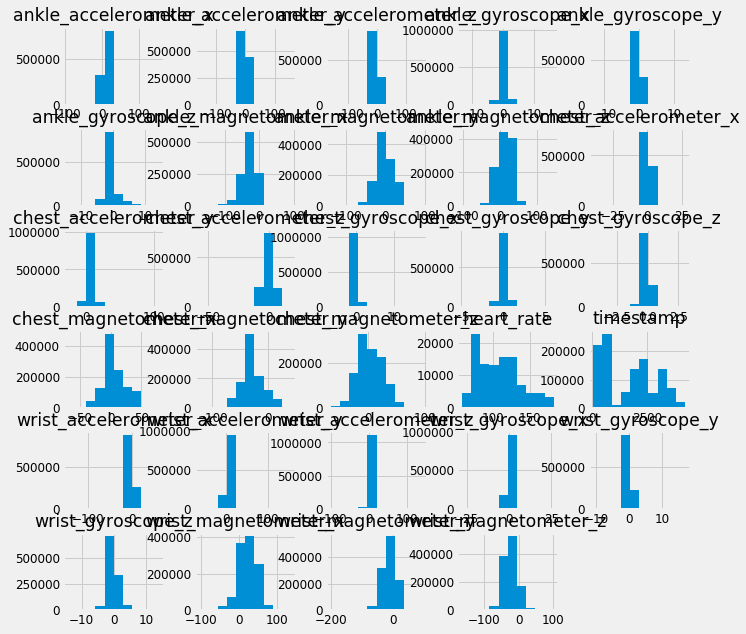

In [80]:
plt.figure(figsize=(13,5))
df_.hist()

In [96]:
#  activity_id count  with origin data 
df.activity_id.value_counts()

walking              207228
lying                168358
standing             164771
sitting              162265
cycling              139125
ascending_stairs     105533
descending_stairs     95289
running               81667
rope_jumping          34163
Name: activity_id, dtype: int64

In [95]:
#  activity_id count with filter data (non-null in observation except heart rate )
df_.activity_id.value_counts()

walking              199366
lying                168131
standing             163915
sitting              161747
cycling              138072
ascending_stairs     105415
descending_stairs     95214
running               79447
rope_jumping          32726
Name: activity_id, dtype: int64

In [97]:
# pivot table on user VS acivity count 

df_user_acivity_count = df_.groupby(['user_id','activity_id']).count()['wrist_accelerometer_x'].reset_index()
pd.pivot_table(df_user_acivity_count, index='user_id',columns='activity_id').reset_index().fillna(0).set_index('user_id')



wrist_accelerometer_x                                      \
activity_id      ascending_stairs  cycling descending_stairs    lying   
user_id                                                                 
a                         15875.0  23492.0           14892.0  27179.0   
b                         17334.0  24595.0           15190.0  23272.0   
c                         10366.0      0.0           15268.0  22041.0   
d                         16683.0  22609.0           14279.0  23029.0   
e                         14250.0  24361.0           12715.0  23670.0   
f                         13285.0  20432.0           11258.0  23330.0   
g                         17622.0  22583.0           11612.0  25610.0   

                                                              
activity_id rope_jumping  running  sitting standing  walking  
user_id                                                       
a                12224.0  20684.0  23465.0  21593.0  21383.0  
b                12801.0   8775.0  22322.0  25416.0  31500.0  
c                    0.0      0.0  28738.0  20408.0  28293.0  
d                    0.0      1.0  25478.0  24651.0  30030.0  
e                 7448.0  24301.0  26720.0  22071.0  30553.0  
f                  253.0  22191.0  22808.0  24064.0  25356.0  
g                    0.0   3495.0  12216.0  25712.0  32251.0

### 1-2) Sequence

In [58]:
df.iloc[:,3:]

,wrist_accelerometer_x,wrist_accelerometer_y,wrist_accelerometer_z,wrist_gyroscope_x,wrist_gyroscope_y,wrist_gyroscope_z,wrist_magnetometer_x,wrist_magnetometer_y,wrist_magnetometer_z,chest_accelerometer_x,...,ankle_accelerometer_x,ankle_accelerometer_y,ankle_accelerometer_z,ankle_gyroscope_x,ankle_gyroscope_y,ankle_gyroscope_z,ankle_magnetometer_x,ankle_magnetometer_y,ankle_magnetometer_z,user_id
0,2.215300,8.279150,5.587530,-0.004750,0.037579,-0.011145,8.93200,-67.9326,-19.97550,0.124482,...,9.738550,-1.847610,0.095156,0.002908,-0.027714,0.001752,-61.1081,-36.86360,-58.3696,a
1,2.291960,7.672880,5.744670,-0.171710,0.025479,-0.009538,9.58300,-67.9584,-20.90910,0.200711,...,9.697620,-1.884380,-0.020804,0.020882,0.000945,0.006007,-60.8916,-36.31970,-58.3656,a
2,2.290900,7.142400,5.823420,-0.238241,0.011214,0.000831,9.05516,-67.4017,-19.50830,0.270277,...,9.696330,-1.922030,-0.059173,-0.035392,-0.052422,-0.004882,-60.3407,-35.78420,-58.6119,a
3,2.218000,7.143650,5.899300,-0.192912,0.019053,0.013374,9.92698,-67.4387,-20.56020,0.236737,...,9.663700,-1.847140,0.094385,-0.032514,-0.018844,0.026950,-60.7646,-37.10280,-57.8799,a
4,2.301060,7.258570,6.092590,-0.069961,-0.018328,0.004582,9.15626,-67.1825,-20.08570,0.352225,...,9.775780,-1.885820,0.095775,0.001351,-0.048878,-0.006328,-60.2040,-37.12250,-57.8847,a
5,2.071650,7.259650,6.012180,0.063895,0.007175,0.024701,8.60505,-66.7184,-19.84290,0.271221,...,9.657800,-1.921470,-0.098161,0.003793,-0.026906,0.004125,-61.3257,-36.97440,-57.7501,a
6,2.411480,7.597800,5.939150,0.190837,0.003116,0.038762,9.16003,-66.8578,-19.96650,0.274553,...,9.658390,-1.807560,-0.098862,0.036814,-0.032277,-0.006866,-61.5520,-36.96320,-57.9957,a
7,2.328150,7.634310,5.706860,0.200328,-0.009266,0.068567,9.47898,-67.3025,-20.66930,0.238925,...,9.656900,-1.883180,-0.136998,-0.010352,-0.016621,0.006548,-61.5738,-36.17240,-59.3487,a
8,2.250960,7.785980,5.628210,0.204098,-0.068256,0.050000,9.15218,-67.0705,-20.31590,0.349738,...,9.777270,-1.810200,0.133911,0.039346,0.020393,-0.011880,-61.7741,-37.17440,-58.1199,a
9,2.141070,7.522620,5.781410,0.171291,-0.055411,0.021576,9.49746,-66.7700,-19.85370,0.120851,...,9.694920,-1.769510,-0.137313,0.029874,-0.010763,0.005133,-60.7680,-37.42060,-58.8735,a


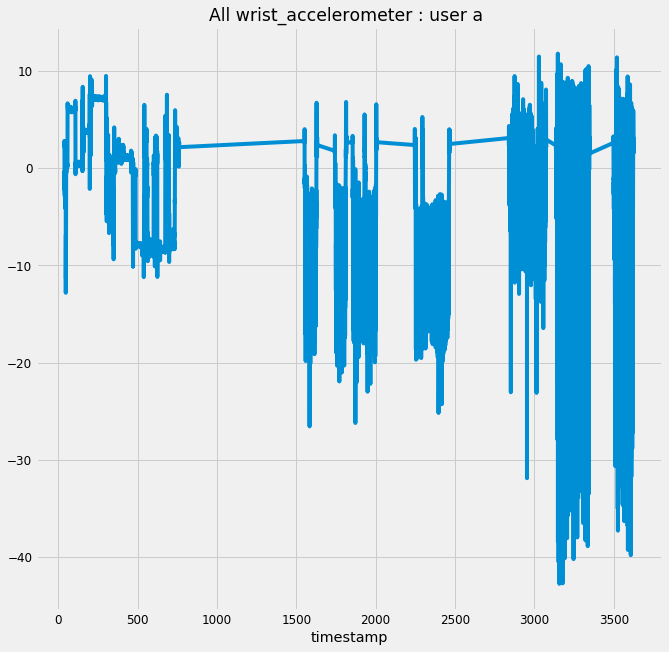

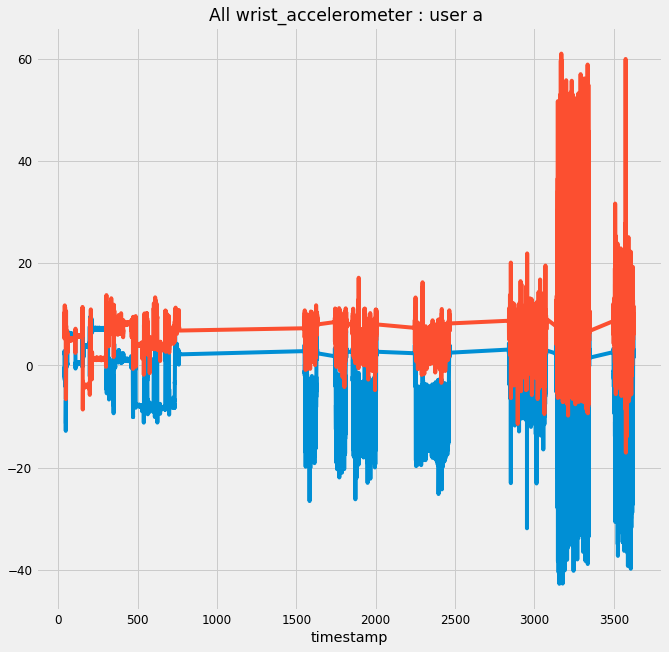

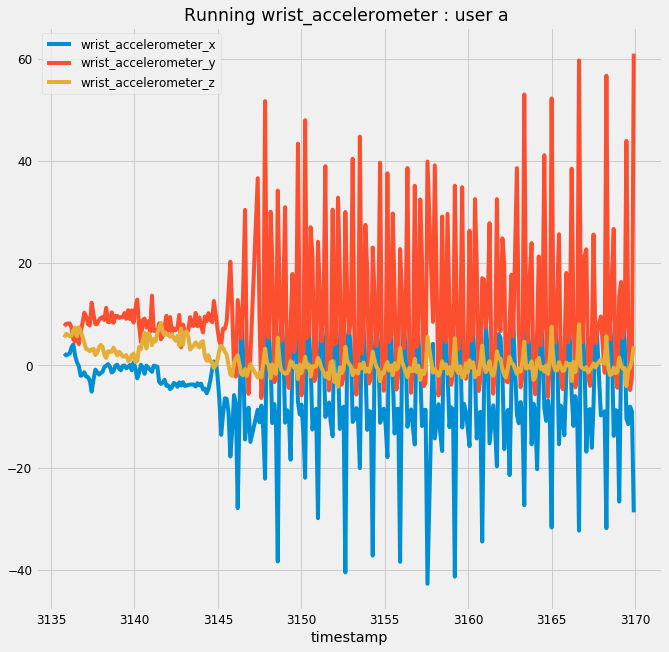

In [49]:
# user a 

#  -------- fig 1 : wrist_accelerometer with User a  -------- # 
df_[(df_.user_id=='a') ]\
  .set_index('timestamp')\
  .wrist_accelerometer_x.plot() 
plt.title('All wrist_accelerometer : user a ')
plt.show()


#  -------- fig 2 : wrist_accelerometer with User a  -------- # 
df_[(df_.user_id=='a') ]\
  .set_index('timestamp')\
  .wrist_accelerometer_x.plot() 

df_[(df_.user_id=='a') ]\
  .set_index('timestamp')\
  .wrist_accelerometer_y.plot() 

plt.title('All wrist_accelerometer : user a ')
plt.show()


  
# -------- fig 3  : wrist_accelerometer with User a when running  -------- # 
df_[(df_.user_id=='a') & (df_.activity_id=='running') &  (df_.timestamp <= 3170) ]\
  .set_index('timestamp')\
  .wrist_accelerometer_x.plot() 


df_[(df_.user_id=='a') & (df_.activity_id=='running') &  (df_.timestamp <= 3170) ]\
  .set_index('timestamp')\
  .wrist_accelerometer_y.plot() 



df_[(df_.user_id=='a') & (df_.activity_id=='running') &  (df_.timestamp <= 3170) ]\
  .set_index('timestamp')\
  .wrist_accelerometer_z.plot() 

plt.legend(['wrist_accelerometer_x','wrist_accelerometer_y','wrist_accelerometer_z'])
plt.title('Running wrist_accelerometer : user a ')
plt.show()